In [4]:
from sklearn.linear_model import MultiTaskElasticNetCV, El
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize
from scipy.stats import pearsonr
import pandas
%matplotlib inline
import matplotlib.pyplot as plt 

In [ ]:
#original as in PLOS paper 
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/original.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

drop_list = [ u'all_cst', u'tot_seq_recovery', u'SR_1', u'SR_1_all_cst', u'SR_2', u'SR_2_all_cst', u'SR_3', u'SR_3_all_cst', u'SR_4', u'SR_4_all_cst', u'SR_5', u'SR_5_all_cst' ]
df.drop( drop_list, inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

X = df.join( train_set ).dropna()
y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV()

params_grid = {
    'cv': [ 3, 4, 5, 10 ], 
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print 'Model score:', grid.score( X, y )
print 'Found params:', grid.best_params_
preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [ ]:
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/nstruct100.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

X = df.join( train_set ).dropna()
y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV()

params_grid = {
    'cv': [ 3, 4, 5, 10 ], 
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_
preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

UnboundLocalError: local variable 'best_l1_ratio' referenced before assignment

0.243211386237
{'l1_ratio': 0.001, 'cv': 50}


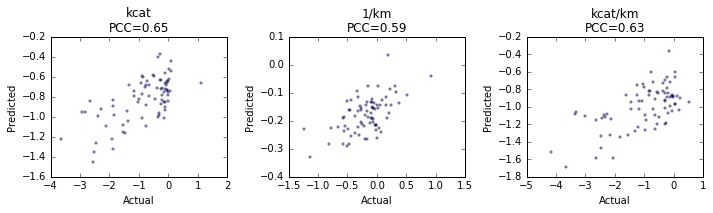

In [35]:
df = pandas.read_csv( 'benchmarks/detect.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df.set_index( 'description', inplace=True )
train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV( selection='random', normalize=True )

params_grid = {
    'cv': [ 3, 4, 5, 10, 25, 50 ], 
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_

preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [40]:
!ls benchmarks/

clean_repack_score.sc nstruct100.sc         whole.sc
detect.sc             original.sc           whole10.sc


0.103133219367
{'l1_ratio': 0.001, 'cv': 10}


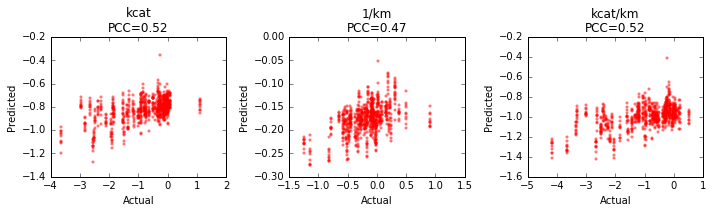

In [41]:
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/whole10.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV( selection='random', normalize=True )

params_grid = {
    'cv': [ 3, 6, 10 ], 
    'l1_ratio': [ 0.0001, 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_

preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.', color='red' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

0.125762983848
{'l1_ratio': 0.0001, 'cv': 3}
[array([-1.13734885]), array([-1.20664737]), array([-1.01748297]), array([-0.72510618]), array([-0.79872167]), array([-0.7785601]), array([-0.90493561]), array([-0.70778071]), array([-1.09418893]), array([-0.95431775]), array([-1.00592894]), array([-0.6091313]), array([-0.73410294]), array([-0.82366865]), array([-0.79160285]), array([-0.51611635]), array([-1.00494813]), array([-0.67463987]), array([-0.57489236]), array([-1.01755561]), array([-0.85470211]), array([-0.71979504]), array([-0.98444607]), array([-1.10157618]), array([-0.72908231]), array([-1.16014351]), array([-0.86964183]), array([-0.64468557]), array([-0.90571188]), array([-1.0208697]), array([-0.87513969]), array([-0.93082904]), array([-0.6476962]), array([-0.66884305]), array([-0.82571316]), array([-0.79465104]), array([-1.00822254]), array([-0.5571882]), array([-0.60490112]), array([-0.82518824]), array([-1.04066356]), array([-0.52019723]), array([-0.69742716]), array([-0.770

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

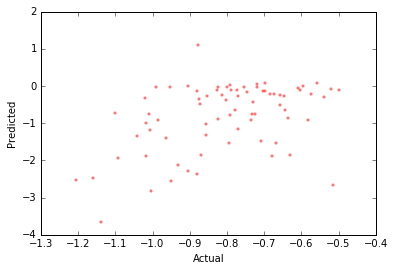

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.0965483677063
{'l1_ratio': 0.0001, 'cv': 3}
[array([-0.26268122]), array([-0.29801612]), array([-0.24944026]), array([-0.16030061]), array([-0.16923178]), array([-0.22308702]), array([-0.30493068]), array([-0.143523]), array([-0.20686114]), array([-0.16448877]), array([-0.21936519]), array([-0.12387063]), array([-0.15345531]), array([-0.16260002]), array([-0.15744102]), array([-0.09969069]), array([-0.22640932]), array([-0.16400448]), array([-0.18367636]), array([-0.28326869]), array([-0.13164275]), array([-0.09322964]), array([-0.18492402]), array([-0.18353587]), array([-0.19861443]), array([-0.18442395]), array([-0.24684715]), array([-0.14317239]), array([-0.19385843]), array([-0.22096545]), array([-0.1933301]), array([-0.22020416]), array([-0.20860288]), array([-0.08972854]), array([-0.15477987]), array([-0.21453467]), array([-0.20664402]), array([-0.08358406]), array([-0.12791858]), array([-0.23250133]), array([-0.29041136]), array([-0.08721785]), array([-0.09834087]), array([-0.

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

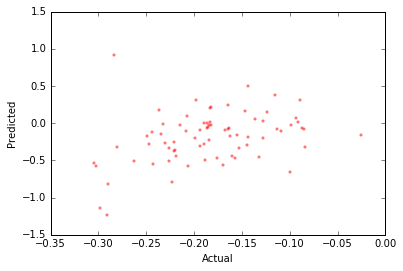

0.247084211563
{'l1_ratio': 0.01, 'cv': 6}
[array([-1.79059136]), array([-2.00745931]), array([-1.82925818]), array([-0.87356286]), array([-0.86471831]), array([-0.8804871]), array([-1.36058189]), array([-0.80104186]), array([-1.66149704]), array([-1.12235353]), array([-1.45326085]), array([-0.48988618]), array([-0.71430703]), array([-1.07290484]), array([-0.88885974]), array([-0.27531559]), array([-1.46357325]), array([-0.55480754]), array([-0.44580655]), array([-1.49760873]), array([-1.00286793]), array([-0.52749449]), array([-1.4393488]), array([-1.51167486]), array([-0.81054257]), array([-1.61398317]), array([-1.19599471]), array([-0.53048107]), array([-1.20833737]), array([-1.4799669]), array([-1.15738482]), array([-1.32193923]), array([-0.68548319]), array([-0.5182197]), array([-0.94402963]), array([-1.05126086]), array([-1.38054382]), array([-0.48938093]), array([-0.45436188]), array([-1.12506406]), array([-1.80608965]), array([-0.29768998]), array([-0.61242616]), array([-0.9637

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

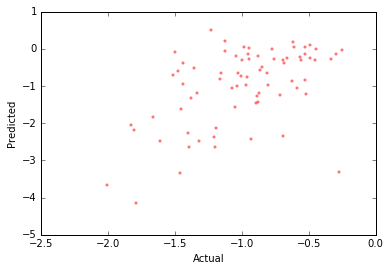

In [43]:
from sklearn.linear_model import ElasticNetCV

def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/whole.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
#df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

yy = [ X.kcat, X['1/km'], X['kcat/km'] ]
X = X.ix[:,:'expressed'] 

fig, ax = plt.subplots()

for y in yy:
    net = ElasticNetCV()

    params_grid = {
        'cv': [ 3, 6, 10 ], 
        'l1_ratio': [ 0.0001, 0.001, 0.01, 0.1, 0.5 ], 
    }

    grid = GridSearchCV( net, params_grid )
    grid.fit( X, y )

    print grid.score( X, y )
    print grid.best_params_

    preds = [ grid.predict( X.iloc[i].reshape( 1, -1 )[0] ) for i in range( len( X ) ) ]

    actuals = [ y.iloc[i] for i in range( len( X ) ) ]
    print preds, actuals
    plt.scatter( preds, actuals, alpha=0.4, marker='.', color='red' )
    plt.xlabel( 'Actual' )
    plt.ylabel( 'Predicted' )
    #plt.title( '{}\nPCC={:.2}'.format( 'whatever', pearsonr( preds, actuals ) ) )
    plt.show()

In [51]:
#original as in PLOS paper 
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/original.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

drop_list = [ u'all_cst', u'tot_seq_recovery', u'SR_1', u'SR_1_all_cst', u'SR_2', u'SR_2_all_cst', u'SR_3', u'SR_3_all_cst', u'SR_4', u'SR_4_all_cst', u'SR_5', u'SR_5_all_cst' ]
df.drop( drop_list, inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

X = df.join( train_set ).dropna()
y = X.kcat
X = X.ix[:,:'expressed'] 

from sklearn.cross_validation import StratifiedKFold
strat = StratifiedKFold( y=y, n_folds=90 )
net = ElasticNetCV(cv=strat)

params_grid = {
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

from sklearn.ensemble import BaggingRegressor
grid = GridSearchCV( net, params_grid )
bag = BaggingRegressor( base_estimator = grid )

bag.fit( X, y )

ValueError: Parameter values should be a list.

In [45]:
print 'Model score:', bag.score( X, y )

Model score: 0.312526851124


In [46]:
preds = [ bag.predict( X.iloc[i].reshape(1,-1) )[0] for i in range( len( X ) ) ] 

(0.55945600691962538, 5.4923497733341174e-63)


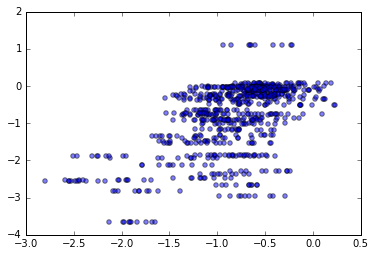

In [47]:
plt.scatter( preds, y, alpha=0.5 )
print pearsonr( preds, y )

In [56]:
!rsync -avz $ep:bagel-learn/benchmark/features_reporter/features.db3 .

receiving file list ... done
features.db3

sent 42 bytes  received 753373 bytes  502276.67 bytes/sec
total size is 1942528  speedup is 2.58


In [57]:
!ls

Untitled.ipynb    benchmarks        elastic_net.ipynb features.db3


Model score: 0.20600002134
Found params: {'l1_ratio': 0.01, 'cv': 10}


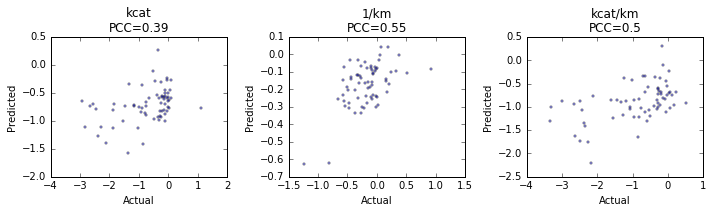

In [116]:
import sqlite3
from sklearn.cross_validation import cross_val_predict
from sklearn.ensemble import BaggingRegressor

con = sqlite3.connect( 'features.db3' )
for i in [ 'interfaces' ]:
    f = pandas.read_sql_query( 'select * from {}'.format( i ), con, index_col='struct_id' )

names = pandas.read_sql_query( 'select * from structures', con, index_col='struct_id' )
feats = f.join( names ).dropna()
#print f.head()
#print names.head()
#print feats.head()

feats['shlag'] = feats.tag.str[:-10]
feats.set_index( 'shlag', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

J = feats.join( train_set ).dropna()

y = J.ix[:,'kcat':]
X = J.ix[:,'dSASA':'batch_id'] 

net = MultiTaskElasticNetCV( )
params_grid = { 'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 'cv': [ 10 ] }
grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print 'Model score:', grid.score( X, y )
print 'Found params:', grid.best_params_
preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

#bag = BaggingRegressor( base_estimator = grid )
#bag.fit( X, y )

#net = ElasticNetCV(cv=strat)

#preds = cross_val_predict( bag, X, y=y, cv=strat )
#net.fit( X, y )
#constants = ['kcat', '1/km', 'kcat/km']
#preds = pandas.DataFrame( preds, columns=constants )
#actuals = pandas.DataFrame( y, columns=constants )
#for c in constants:
#    plt.scatter( preds[c], actuals[c] )
#    plt.show()

In [ ]:

#X = df.join( train_set ).dropna()

#y = X.ix[:,'kcat':]
#X = X.ix[:,:'expressed'] 

#net = MultiTaskElasticNetCV( selection='random', normalize=True )

#params_grid = {
#    'cv': [ 3, 4, 5, 10, 25, 50 ], 
#    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
#}

#grid = GridSearchCV( net, params_grid )
#grid.fit( X, y )

#print grid.score( X, y )
#print grid.best_params_

#preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
#actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

#fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
#for i in range( 3 ):
#    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
#    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
#    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
#    ax[i].set_xlabel( 'Actual' )
#    ax[i].set_ylabel( 'Predicted' )
#   ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
#    plt.tight_layout()